In [1]:
import json
import base64
import qrcode
import requests
import datetime
import uuid
import matplotlib.pyplot as plt
from IPython import display
from pymongo import MongoClient
from typing import Optional, List
from didcomm.common.types import DID, VerificationMethodType, VerificationMaterial, VerificationMaterialFormat
from didcomm.did_doc.did_doc import DIDDoc, VerificationMethod, DIDCommService
from didcomm.did_doc.did_resolver import DIDResolver
from didcomm.message import Message, FromPrior
from didcomm.secrets.secrets_resolver_demo import SecretsResolverDemo
from didcomm.unpack import unpack, UnpackResult
from didcomm.common.resolvers import ResolversConfig
from didcomm.pack_encrypted import pack_encrypted, PackEncryptedConfig, PackEncryptedResult
from peerdid.core.did_doc_types import DIDCommServicePeerDID
from didcomm.secrets.secrets_util import generate_x25519_keys_as_jwk_dict, generate_ed25519_keys_as_jwk_dict, jwk_to_secret
from peerdid import peer_did
from peerdid.did_doc import DIDDocPeerDID
from peerdid.types import VerificationMaterialAuthentication, VerificationMethodTypeAuthentication, VerificationMaterialAgreement, VerificationMethodTypeAgreement, VerificationMaterialFormatPeerDID

In [2]:
secrets_resolver = SecretsResolverDemo()

In [3]:
class DIDResolverPeerDID(DIDResolver):
    async def resolve(self, did: DID) -> DIDDoc:
        did_doc_json = peer_did.resolve_peer_did(did, format = VerificationMaterialFormatPeerDID.JWK)
        did_doc = DIDDocPeerDID.from_json(did_doc_json)

        return DIDDoc(
            did=did_doc.did,
            key_agreement_kids = did_doc.agreement_kids,
            authentication_kids = did_doc.auth_kids,
            verification_methods = [
                VerificationMethod(
                    id = m.id,
                    type = VerificationMethodType.JSON_WEB_KEY_2020,
                    controller = m.controller,
                    verification_material = VerificationMaterial(
                        format = VerificationMaterialFormat.JWK,
                        value = json.dumps(m.ver_material.value)
                    )
                )
                for m in did_doc.authentication + did_doc.key_agreement
            ],
             didcomm_services = []
#                 DIDCommService(
#                     id = s.id,
#                     service_endpoint = s.service_endpoint,
#                     routing_keys = s.routing_keys,
#                     accept = s.accept
#                 )
#                 for s in did_doc.service
#                 if isinstance(s, DIDCommServicePeerDID)
#            ] if did_doc.service else []
        )

In [4]:
async def create_peer_did(self,
                        auth_keys_count: int = 1,
                        agreement_keys_count: int = 1,
                        service_endpoint: Optional[str] = None,
                        service_routing_keys: Optional[List[str]] = None
                        ) -> str:
        # 1. generate keys in JWK format
        agreem_keys = [generate_x25519_keys_as_jwk_dict() for _ in range(agreement_keys_count)]
        auth_keys = [generate_ed25519_keys_as_jwk_dict() for _ in range(auth_keys_count)]

        # 2. prepare the keys for peer DID lib
        agreem_keys_peer_did = [
            VerificationMaterialAgreement(
                type=VerificationMethodTypeAgreement.JSON_WEB_KEY_2020,
                format=VerificationMaterialFormatPeerDID.JWK,
                value=k[1],
            )
            for k in agreem_keys
        ]
        auth_keys_peer_did = [
            VerificationMaterialAuthentication(
                type=VerificationMethodTypeAuthentication.JSON_WEB_KEY_2020,
                format=VerificationMaterialFormatPeerDID.JWK,
                value=k[1],
            )
            for k in auth_keys
        ]

        # 3. generate service
        service = None
        if service_endpoint:
            service = json.dumps(
                DIDCommServicePeerDID(
                    id="new-id",
                    service_endpoint=service_endpoint, routing_keys=service_routing_keys,
                    accept=["didcomm/v2"]
                ).to_dict()
            )

        # 4. call peer DID lib
        # if we have just one key (auth), then use numalg0 algorithm
        # otherwise use numalg2 algorithm
        if len(auth_keys_peer_did) == 1 and not agreem_keys_peer_did and not service:
            did = peer_did.create_peer_did_numalgo_0(auth_keys_peer_did[0])
        else:
            did = peer_did.create_peer_did_numalgo_2(
                encryption_keys=agreem_keys_peer_did,
                signing_keys=auth_keys_peer_did,
                service=service,
            )

        # 5. set KIDs as in DID DOC for secrets and store the secret in the secrets resolver
        did_doc = DIDDocPeerDID.from_json(peer_did.resolve_peer_did(did))
        for auth_key, kid in zip(auth_keys, did_doc.auth_kids):
            private_key = auth_key[0]
            private_key["kid"] = kid
            await secrets_resolver.add_key(jwk_to_secret(private_key))

        for agreem_key, kid in zip(agreem_keys, did_doc.agreement_kids):
            private_key = agreem_key[0]
            private_key["kid"] = kid
            await secrets_resolver.add_key(jwk_to_secret(private_key))

        return did


### Alice get OOB from Mediator

In [5]:
#oob_url = requests.get("http://127.0.0.1:8000/oob_url").text
oob_url = requests.get("https://mediator.rootsid.cloud/oob_url").text

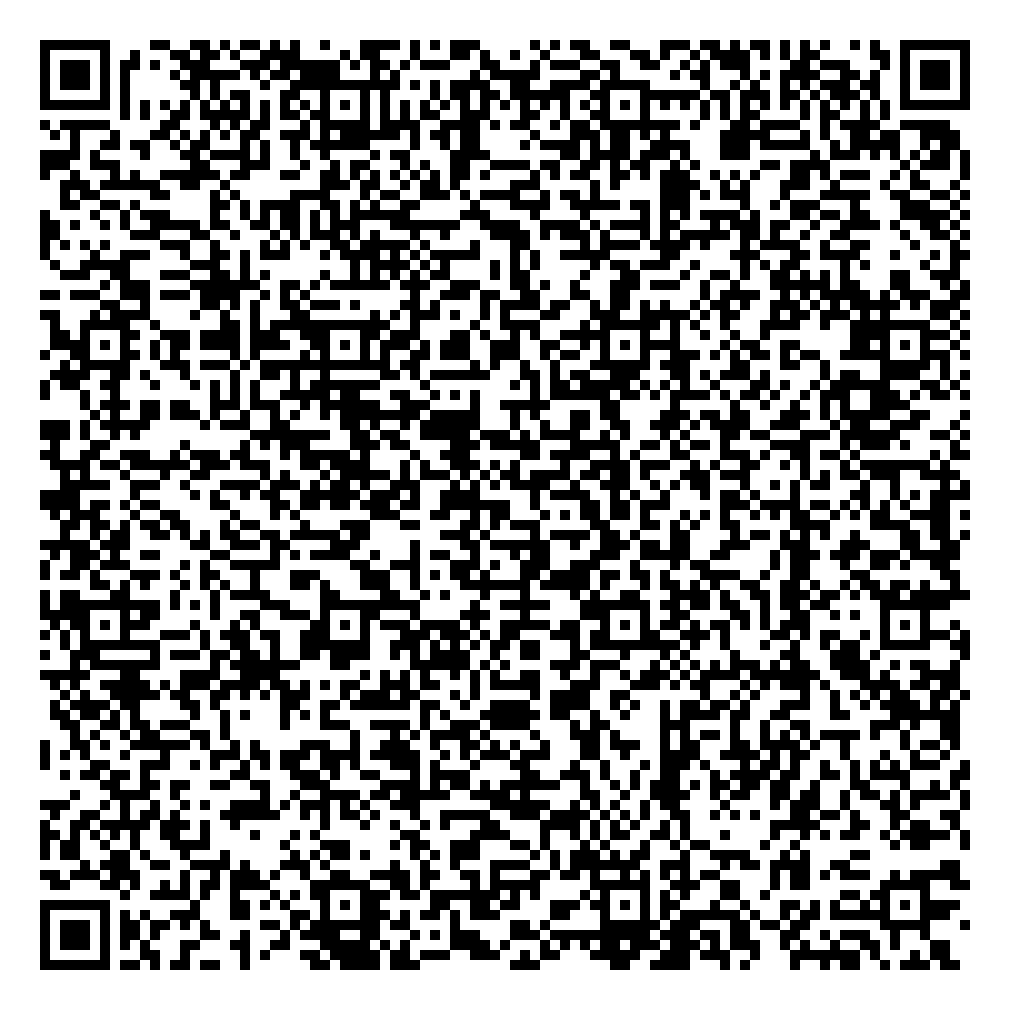

In [6]:
im = qrcode.make(oob_url)
im.save('qr.png')
display.Image('qr.png',width=500,height=500)

In [7]:
received_msg_encoded = oob_url.split("=")[1]
received_msg_decoded = json.loads(str(base64.urlsafe_b64decode(received_msg_encoded + "=="), "utf-8"))
alice_did_for_mediator = await create_peer_did(1,1)
print("Alice's DID:", alice_did_for_mediator)

Alice's DID: did:peer:2.Ez6LSiopL5aJjRbTu8ZB8uinhodhP7GiSix9DFG5rr2Xp93mg.Vz6MkrnJCtTmSuhoVXUSS8CxZkesWuwHaeHbyp7NT3Z3c9ZoA


### Alice request mediate

In [8]:
alice_mediate_grant = Message(
    custom_headers = [{"return_route": "all"}],
    id = str(uuid.uuid4()),
    type = "https://didcomm.org/coordinate-mediation/2.0/mediate-request",
    body = {}
)

In [9]:
alice_mediate_grant_packed = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = alice_mediate_grant,
    frm = alice_did_for_mediator,
    to = received_msg_decoded["from"],
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)

### Sending to Mediator

In [10]:
mediator_did_doc = json.loads(peer_did.resolve_peer_did(received_msg_decoded["from"]))
mediator_endpoint = mediator_did_doc["service"][0]["serviceEndpoint"]
print(mediator_endpoint)

https://mediator.rootsid.cloud


In [11]:
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp = requests.post(mediator_endpoint, headers=headers, json = json.loads(alice_mediate_grant_packed.packed_msg))


In [12]:
print(resp.json())

{'protected': 'eyJ0eXAiOiJhcHBsaWNhdGlvbi9kaWRjb21tLWVuY3J5cHRlZCtqc29uIiwiYWxnIjoiRUNESC0xUFUrQTI1NktXIiwiZW5jIjoiQTI1NkNCQy1IUzUxMiIsImFwdSI6IlpHbGtPbkJsWlhJNk1pNUZlalpNVTNKRWRrNVdXR2g2Y2tzMWFGWnFVM0JxY1RsdmVUSjFVVUpDY1VzME4waFhjMjlCYzBOVWVuWlJXR3BqTGxaNk5rMXJkMFZTVkRZNGNFTjNOV1JJYjBOVlFtbFlTbW95TjB4R1VYTnhkRmRrY21NMVZuTTRXRTQ1VEdkTFFqWXVVMlY1U25CYVEwazJTVzAxYkdSNU1YQmFRMGx6U1c1UmFVOXBTbXRpVTBselNXNU5hVTlwU205a1NGSjNZM3B2ZGt3eU1XeGFSMnhvWkVjNWVVeHVTblppTTFKNllWZFJkVmt5ZUhaa1YxRnBURU5LYUVscWNHSkpiVkp3V2tkT2RtSlhNSFprYWtscFdGZ3dJelpNVTNKRWRrNVdXR2g2Y2tzMWFGWnFVM0JxY1RsdmVUSjFVVUpDY1VzME4waFhjMjlCYzBOVWVuWlJXR3BqIiwiYXB2IjoiLW1IOGp0SXYwS1RjVVhFR083NWQtX3NyTHJFUDRmb0tzbkt4eWU4MUNtUSIsInNraWQiOiJkaWQ6cGVlcjoyLkV6NkxTckR2TlZYaHpySzVoVmpTcGpxOW95MnVRQkJxSzQ3SFdzb0FzQ1R6dlFYamMuVno2TWt3RVJUNjhwQ3c1ZEhvQ1VCaVhKajI3TEZRc3F0V2RyYzVWczhYTjlMZ0tCNi5TZXlKcFpDSTZJbTVsZHkxcFpDSXNJblFpT2lKa2JTSXNJbk1pT2lKb2RIUndjem92TDIxbFpHbGhkRzl5TG5KdmIzUnphV1F1WTJ4dmRXUWlMQ0poSWpwYkltUnBaR052YlcwdmRqSWlYWDAjNkxTc

### Get mediator grant response

In [13]:
mediator_unpack_msg = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg= resp.json()
)
print(mediator_unpack_msg.message.type)
print("Routing Key: " + mediator_unpack_msg.message.body["routing_did"])
print("Mediator new DID: " + mediator_unpack_msg.message.from_prior.sub)
# mediator rotated did
mediator_routing_key = mediator_unpack_msg.message.body["routing_did"]
mediator_did = mediator_unpack_msg.message.from_prior.sub

https://didcomm.org/coordinate-mediation/2.0/mediate-grant
Routing Key: did:peer:2.Ez6LStkafv8VE9FWWx6rQf1ngTGFkX9puq3PGrjeDJtGdT2ZW.Vz6MkpAasNBuwT4ZFPbLEsKvSZjporHnGZ4BQucnPXLi9oUCr.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL21lZGlhdG9yLnJvb3RzaWQuY2xvdWQiLCJhIjpbImRpZGNvbW0vdjIiXX0
Mediator new DID: did:peer:2.Ez6LSrDvNVXhzrK5hVjSpjq9oy2uQBBqK47HWsoAsCTzvQXjc.Vz6MkwERT68pCw5dHoCUBiXJj27LFQsqtWdrc5Vs8XN9LgKB6.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOiJodHRwczovL21lZGlhdG9yLnJvb3RzaWQuY2xvdWQiLCJhIjpbImRpZGNvbW0vdjIiXX0


### Keylist update

Alice create a new DID to share with  other peers using mediator routing keys 

In [14]:
#alice_did_new = await create_peer_did(1, 1, service_endpoint=mediator_endpoint, service_routing_keys=[mediator_routing_key])
alice_did_for_bob = await create_peer_did(1, 1, service_endpoint=[{"uri": mediator_routing_key}])

print("Alice's DID for Bob:", alice_did_for_bob)

Alice's DID for Bob: did:peer:2.Ez6LSofVVYDjMN7SEjt7YELkYnBhabgaHkhMvWTsGXPFvgbDH.Vz6MkuHepk3bYJpznty1ZRdfohqK3j3j341EVkJ4VJWz71kXY.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOlt7InVyaSI6ImRpZDpwZWVyOjIuRXo2TFN0a2FmdjhWRTlGV1d4NnJRZjFuZ1RHRmtYOXB1cTNQR3JqZURKdEdkVDJaVy5WejZNa3BBYXNOQnV3VDRaRlBiTEVzS3ZTWmpwb3JIbkdaNEJRdWNuUFhMaTlvVUNyLlNleUpwWkNJNkltNWxkeTFwWkNJc0luUWlPaUprYlNJc0luTWlPaUpvZEhSd2N6b3ZMMjFsWkdsaGRHOXlMbkp2YjNSemFXUXVZMnh2ZFdRaUxDSmhJanBiSW1ScFpHTnZiVzB2ZGpJaVhYMCJ9XSwiYSI6WyJkaWRjb21tL3YyIl19


Alice create and send the keylist update message

In [15]:
alice_keylist_update = Message(
    id = "unique-id-293e9a922efff",
    type = "https://didcomm.org/coordinate-mediation/2.0/keylist-update",
    body = {
        "updates":[
        {
            "recipient_did": alice_did_for_bob,
            "action": "add"
        }
    ]
    }
)

In [16]:
alice_keylist_update_packed_msg = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = alice_keylist_update,
    frm = alice_did_for_mediator,
    to = mediator_did,
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)

In [17]:
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp = requests.post(mediator_endpoint, headers=headers, data = alice_keylist_update_packed_msg.packed_msg)

In [18]:
mediator_unpack_msg2 = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg= resp.json()
)
print(mediator_unpack_msg2.message.type)
print(mediator_unpack_msg2.message.body)


https://didcomm.org/coordinate-mediation/2.0/keylist-update-response
{'updated': [{'recipient_did': 'did:peer:2.Ez6LSofVVYDjMN7SEjt7YELkYnBhabgaHkhMvWTsGXPFvgbDH.Vz6MkuHepk3bYJpznty1ZRdfohqK3j3j341EVkJ4VJWz71kXY.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOlt7InVyaSI6ImRpZDpwZWVyOjIuRXo2TFN0a2FmdjhWRTlGV1d4NnJRZjFuZ1RHRmtYOXB1cTNQR3JqZURKdEdkVDJaVy5WejZNa3BBYXNOQnV3VDRaRlBiTEVzS3ZTWmpwb3JIbkdaNEJRdWNuUFhMaTlvVUNyLlNleUpwWkNJNkltNWxkeTFwWkNJc0luUWlPaUprYlNJc0luTWlPaUpvZEhSd2N6b3ZMMjFsWkdsaGRHOXlMbkp2YjNSemFXUXVZMnh2ZFdRaUxDSmhJanBiSW1ScFpHTnZiVzB2ZGpJaVhYMCJ9XSwiYSI6WyJkaWRjb21tL3YyIl19', 'action': 'add', 'result': 'success'}]}


### Alice can now send her DID to Bob. Copy Alice's DID into Bob's notebook, and follows Bob's notebook

In [19]:
print(alice_did_for_bob)

did:peer:2.Ez6LSofVVYDjMN7SEjt7YELkYnBhabgaHkhMvWTsGXPFvgbDH.Vz6MkuHepk3bYJpznty1ZRdfohqK3j3j341EVkJ4VJWz71kXY.SeyJpZCI6Im5ldy1pZCIsInQiOiJkbSIsInMiOlt7InVyaSI6ImRpZDpwZWVyOjIuRXo2TFN0a2FmdjhWRTlGV1d4NnJRZjFuZ1RHRmtYOXB1cTNQR3JqZURKdEdkVDJaVy5WejZNa3BBYXNOQnV3VDRaRlBiTEVzS3ZTWmpwb3JIbkdaNEJRdWNuUFhMaTlvVUNyLlNleUpwWkNJNkltNWxkeTFwWkNJc0luUWlPaUprYlNJc0luTWlPaUpvZEhSd2N6b3ZMMjFsWkdsaGRHOXlMbkp2YjNSemFXUXVZMnh2ZFdRaUxDSmhJanBiSW1ScFpHTnZiVzB2ZGpJaVhYMCJ9XSwiYSI6WyJkaWRjb21tL3YyIl19


### Alice check status of queued messages from the Mediator

In [27]:
alice_status_check = Message(
    id = "unique-id-293e9a922efffxxx",
    type = "https://didcomm.org/messagepickup/3.0/status-request",
    body = {}
)

In [28]:
alice_status_check_packed_msg = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = alice_status_check,
    to = mediator_did,
    frm = alice_did_for_mediator,
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp3 = requests.post(mediator_endpoint, headers=headers, data = alice_status_check_packed_msg.packed_msg)

In [29]:
mediator_unpack_status = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg= resp3.json()
)
print(mediator_unpack_status.message.type)
print("Messages in Mediator queue: " + str(mediator_unpack_status.message.body["message_count"]))

https://didcomm.org/messagepickup/3.0/status
Messages in Mediator queue: 1


### If there are messages, Alice can pickup from the mediator (delivery request)

In [30]:
alice_delivery_request = Message(
    id = "unique-id-293e9a922efffxxxff",
    type = "https://didcomm.org/messagepickup/3.0/delivery-request",
    body = {"limit": 1}
)

In [31]:
alice_delivery_request_packed_msg = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = alice_delivery_request,
    to = mediator_did,
    frm = alice_did_for_mediator,
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp4 = requests.post(mediator_endpoint, headers=headers, data = alice_delivery_request_packed_msg.packed_msg)

In [32]:
mediator_delivery = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg= resp4.json()
)
print(mediator_delivery.message.type)
print(mediator_delivery.message.body)

https://didcomm.org/messagepickup/3.0/delivery
{'recipient_key': None}


In [33]:
bob_packed_msg = mediator_delivery.message.attachments[0].data.json
msg_id = mediator_delivery.message.attachments[0].id

In [34]:
print(bob_packed_msg)

{'protected': 'eyJ0eXAiOiJhcHBsaWNhdGlvbi9kaWRjb21tLWVuY3J5cHRlZCtqc29uIiwiYWxnIjoiRUNESC0xUFUrQTI1NktXIiwiZW5jIjoiQTI1NkNCQy1IUzUxMiIsImFwdSI6IlpHbGtPbkJsWlhJNk1pNUZlalpNVTNKWFl6TklObTQxV1V4NWQwSmpRVXBIY1hoTGRVVk1Za0psUVc5Qk9VWjFWWEJwUjFVM1N6bExRMHhFTGxaNk5rMXJhbk01TVVWUmRsVmxkRGx5UjBadlNFZEdkbmhvTlZONFFsVk9VVXcwWm5GaE4zRnZOMHh0Tm1nNFRIZ3VVMlY1U25CYVEwazJTVzAxYkdSNU1YQmFRMGx6U1c1UmFVOXBTbXRpVTBselNXNU5hVTlwU205a1NGSjNZM3B2ZGt3elpETmtlVFZzWlVkR2RHTkhlR3hNYlU1MllsTTVhV0l5U1dsTVEwcG9TV3B3WWtsdFVuQmFSMDUyWWxjd2RtUnFTV2xZV0RBak5reFRjbGRqTTBnMmJqVlpUSGwzUW1OQlNrZHhlRXQxUlV4aVFtVkJiMEU1Um5WVmNHbEhWVGRMT1V0RFRFUSIsImFwdiI6InJyaWNpNXBQUkdtNEFTcWU5ckRLcEttS2ZtLU9rMElyaG1mdmNrVU8wdEEiLCJza2lkIjoiZGlkOnBlZXI6Mi5FejZMU3JXYzNINm41WUx5d0JjQUpHcXhLdUVMYkJlQW9BOUZ1VXBpR1U3SzlLQ0xELlZ6Nk1ranM5MUVRdlVldDlyR0ZvSEdGdnhoNVN4QlVOUUw0ZnFhN3FvN0xtNmg4THguU2V5SnBaQ0k2SW01bGR5MXBaQ0lzSW5RaU9pSmtiU0lzSW5NaU9pSm9kSFJ3Y3pvdkwzZDNkeTVsZUdGdGNHeGxMbU52YlM5aWIySWlMQ0poSWpwYkltUnBaR052YlcwdmRqSWlYWDAjNkxTcldjM0g2bjVZT

In [35]:
bob_msg = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg= bob_packed_msg
)

In [36]:
print("Message ID:", msg_id)
print(bob_msg.message.body["content"])

Message ID: 6435eaeafb5566e28c19e27b
Argentina or Croacia at World Cup finals?


### Alice acknowledge so the mediator can delete the message

In [37]:
alice_ack = Message(
    id = "unique-id-293e9a922efffxxxffsss",
    type = "https://didcomm.org/messagepickup/3.0/messages-received",
    body = {"message_id_list": [msg_id]}
)

In [38]:
alice_ack_packed_msg = await pack_encrypted(
    resolvers_config = ResolversConfig(
        secrets_resolver = secrets_resolver,
        did_resolver = DIDResolverPeerDID()
    ),
    message = alice_ack,
    to = mediator_did,
    frm = alice_did_for_mediator,
    sign_frm = None,
    pack_config = PackEncryptedConfig(protect_sender_id=False)
)
headers = {"Content-Type": "application/didcomm-encrypted+json"}
resp5 = requests.post(mediator_endpoint, headers=headers, data = alice_ack_packed_msg.packed_msg)

In [39]:
mediator_ack_status = await unpack(
    resolvers_config=ResolversConfig(
        secrets_resolver=secrets_resolver,
        did_resolver=DIDResolverPeerDID()
    ),
    packed_msg= resp5.json()
)
print(mediator_ack_status.message.type)
print(mediator_ack_status.message.body)

https://didcomm.org/messagepickup/3.0/status
{'message_count': 0, 'live_delivery': False}
